In [1]:
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# matplotlib.use("agg")

from exp_spec_info import *
from plot_info import *
from select_data import *

In [2]:
# Processed median path
median_data_path = "C:\\Users\\dosre\\dev\\thesis-data\\median_data.pkl"

# Plot output directory
plot_output_root = "C:\\Users\\dosre\\dev\\thesis-data\\plots"
os.makedirs(plot_output_root, exist_ok=True)
pc_gmres_m_plots_dir = os.path.join(plot_output_root, "pc_gmres_m")
os.makedirs(pc_gmres_m_plots_dir, exist_ok=True)

In [3]:
# Load data and filter for only gmres m solvers
median_data = pd.read_pickle(median_data_path)
median_data = median_data[median_data["solver"].transform(lambda x: (x in PC_SOLVERS))]

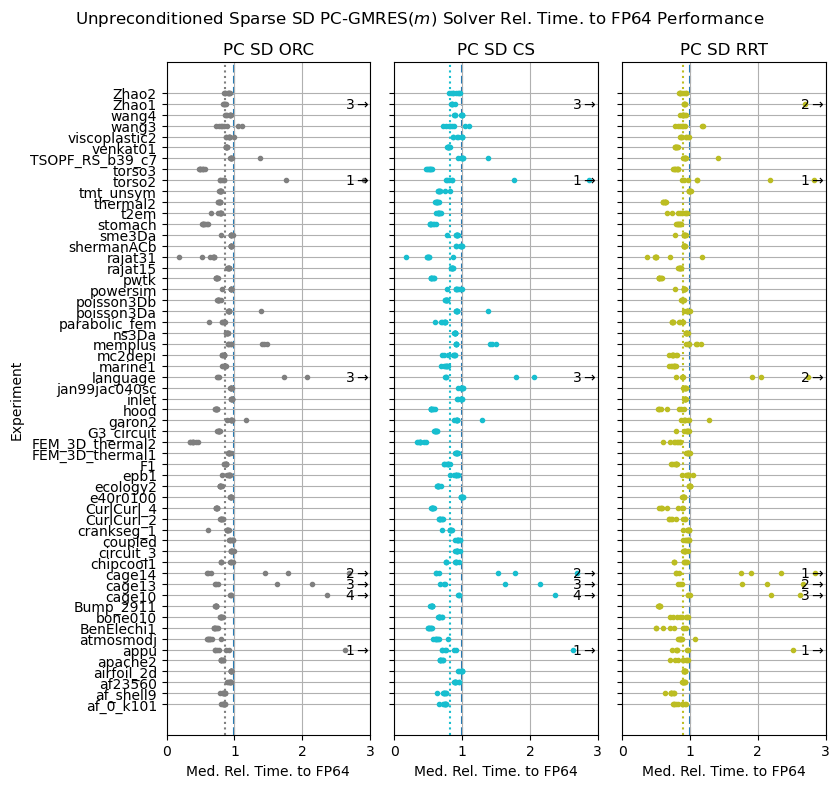

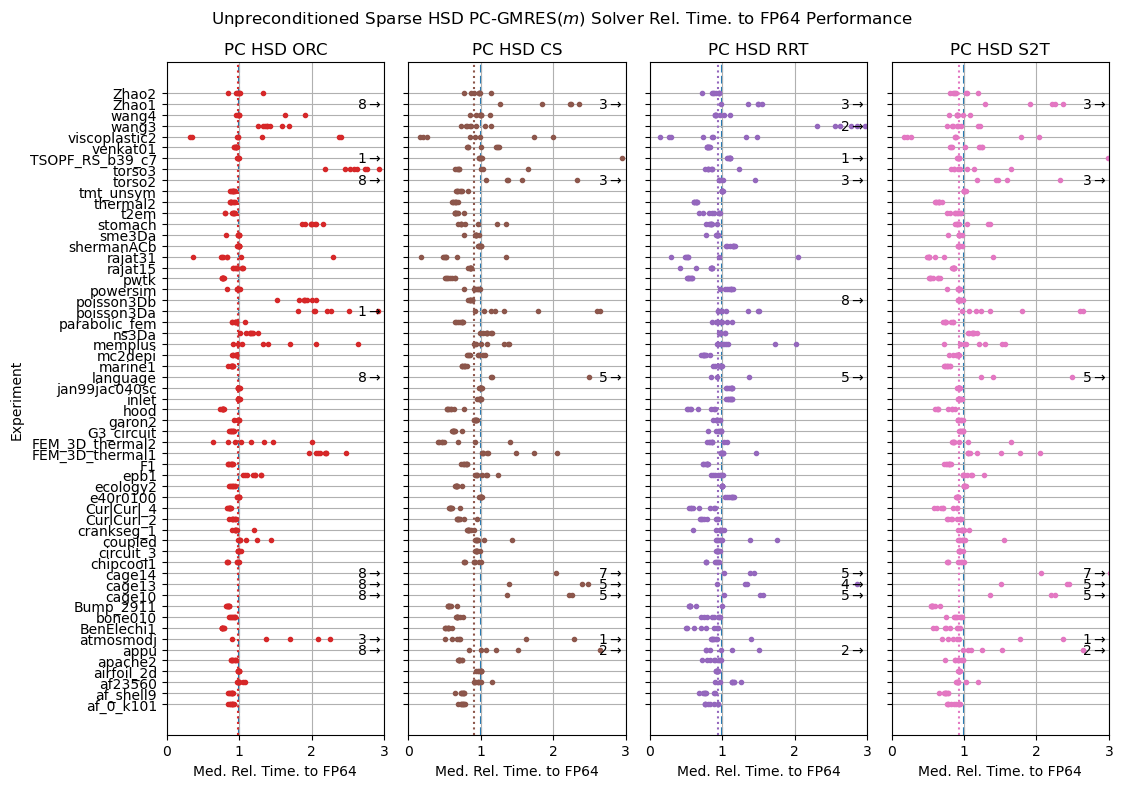

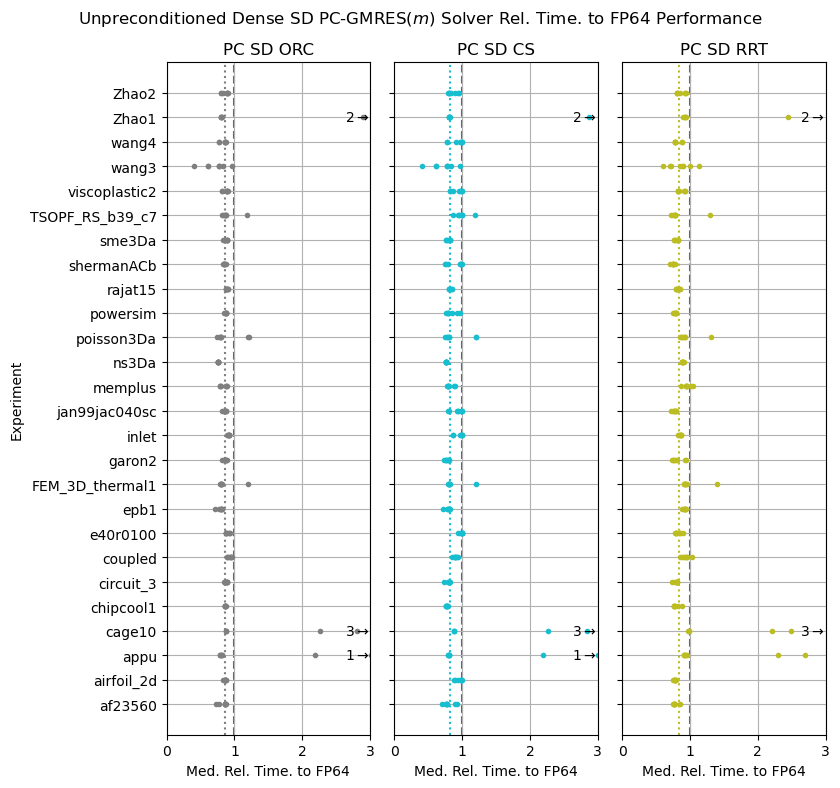

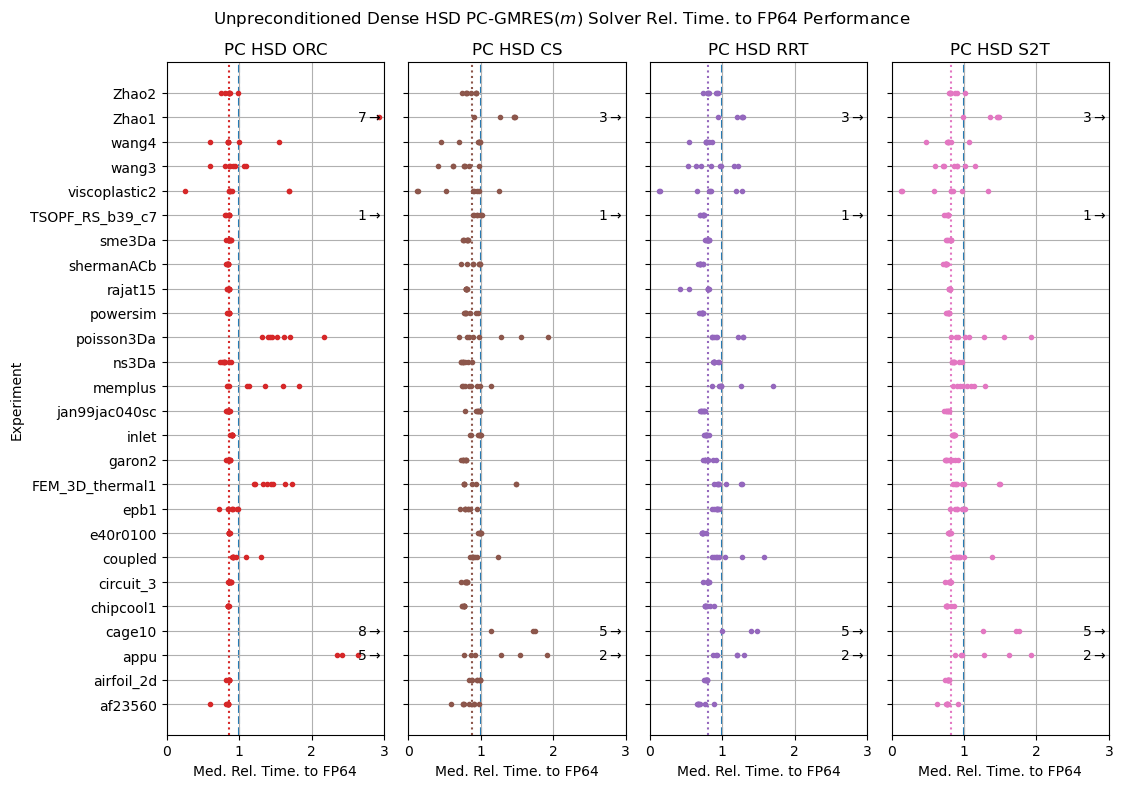

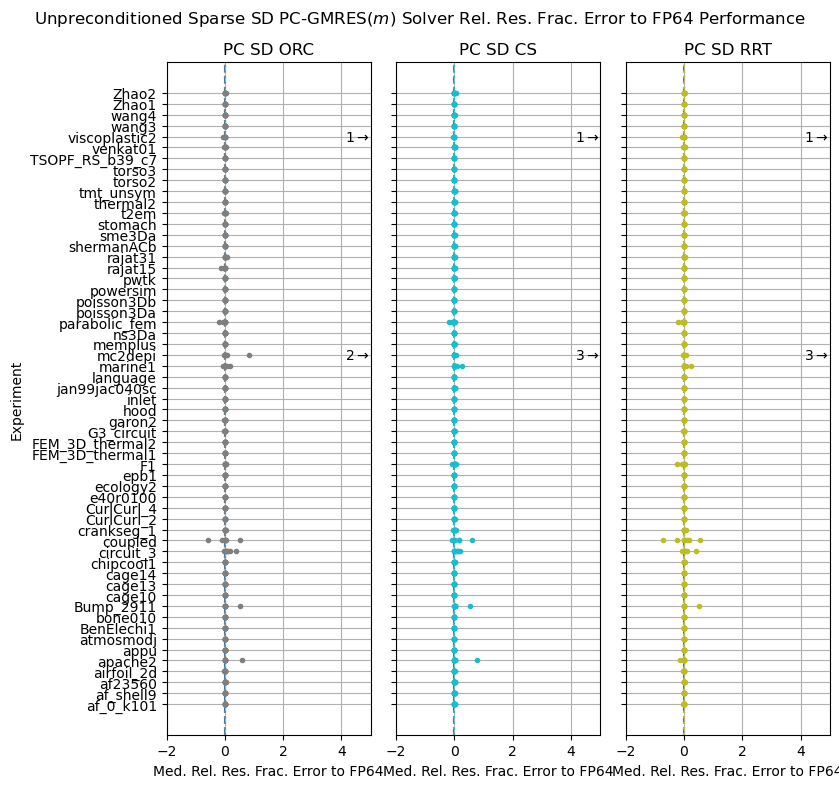

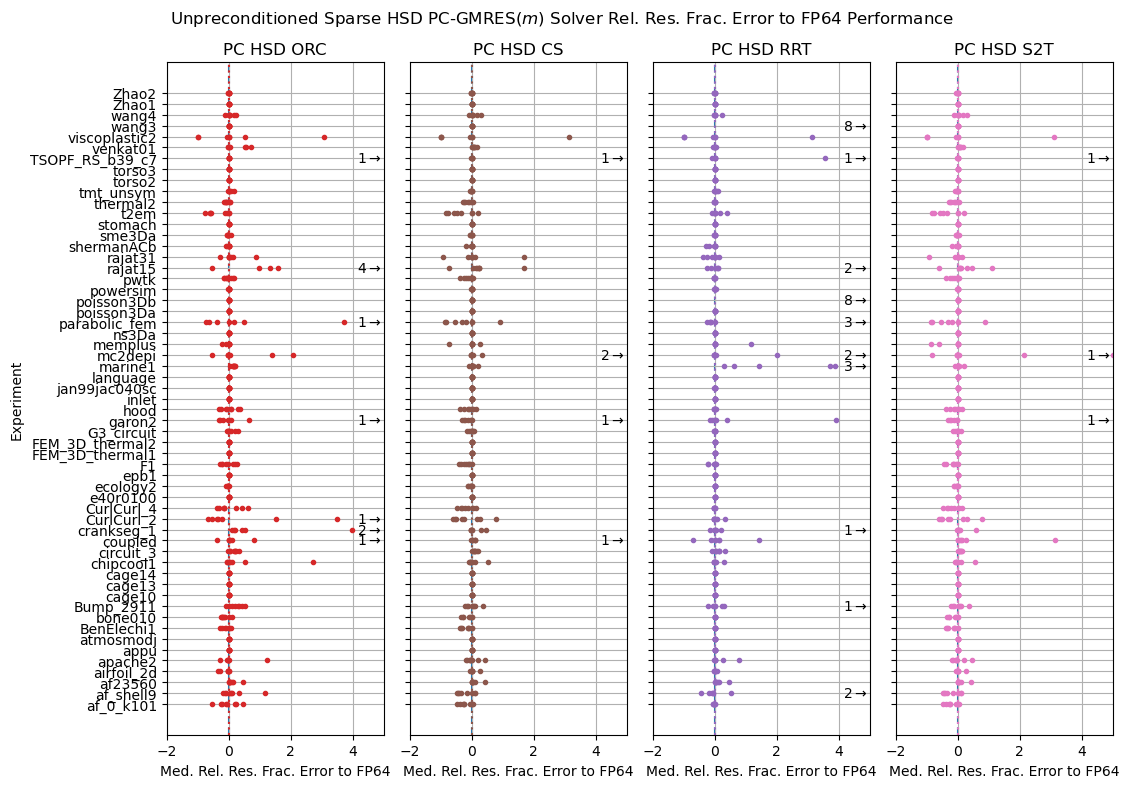

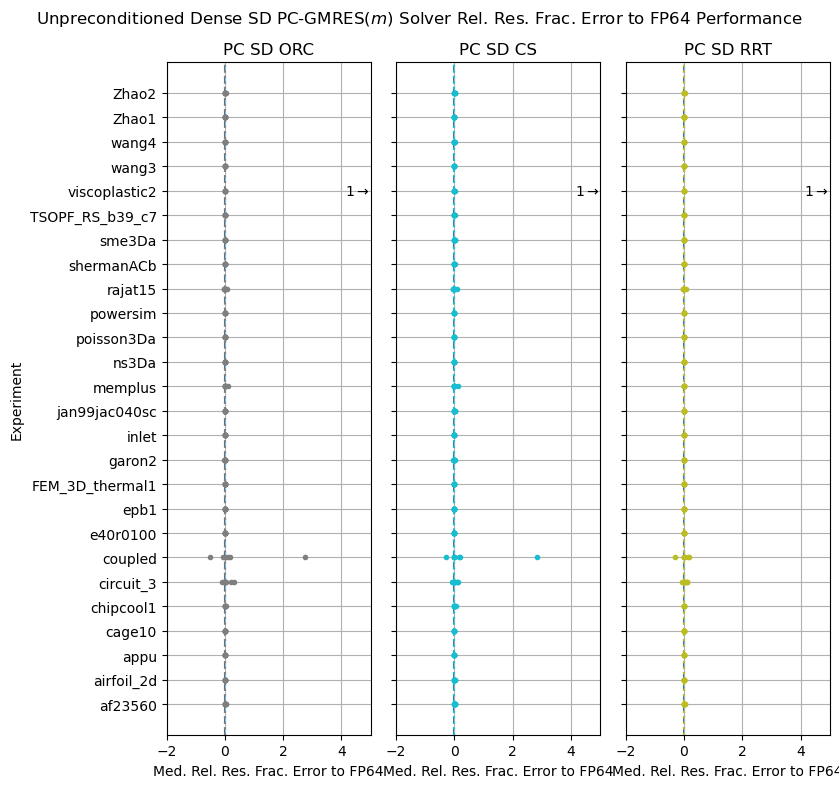

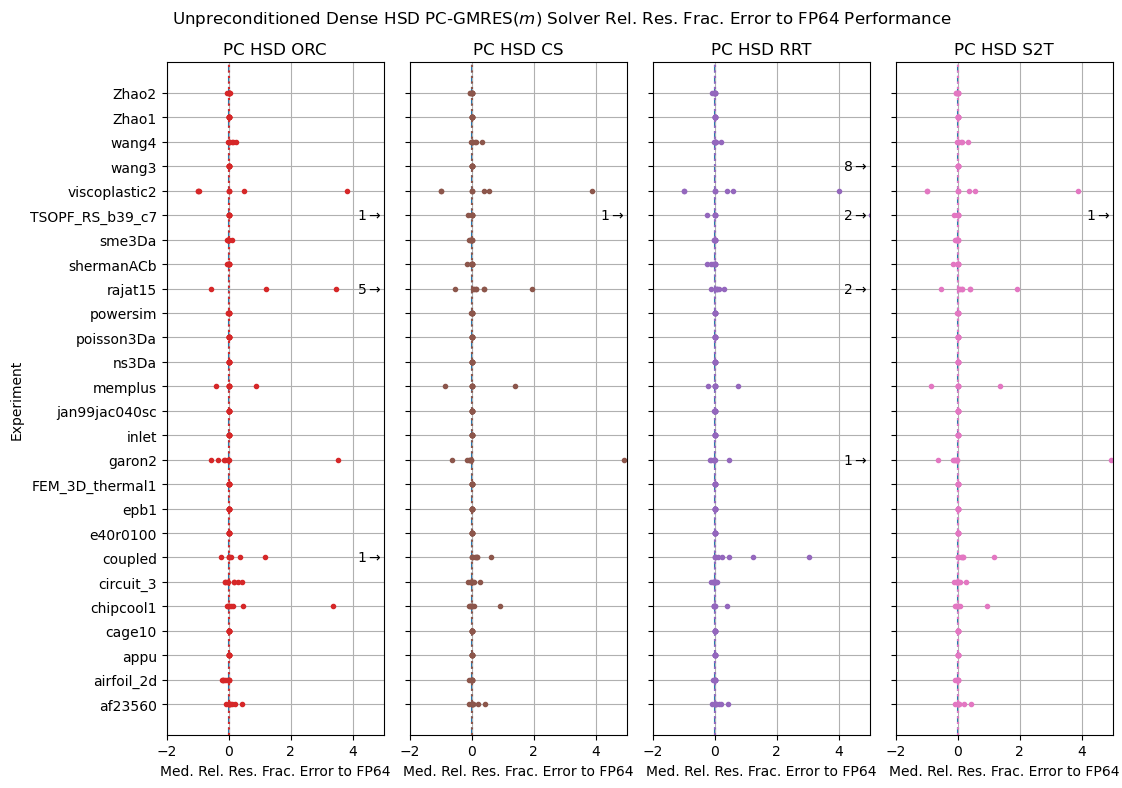

In [18]:
for setup, data_point, data_label, fp64_val, x_range in [
    ("unprecond", "med_rel_time", "Rel. Time. to FP64", 1., [0., 3.]),
    ("unpreconddense", "med_rel_time", "Rel. Time. to FP64", 1., [0., 3.]),
    ("unprecond", "med_rel_res_frac_err", "Rel. Res. Frac. Error to FP64", 0., [-2., 5.]),
    ("unpreconddense", "med_rel_res_frac_err", "Rel. Res. Frac. Error to FP64", 0., [-2., 5.]),
]:

    setup_data = median_data[median_data["setup"] == setup]

    for prefix, solvers in [
        ("SD", ["PC SD ORC", "PC SD CS", "PC SD RRT"]),
        ("HSD", ["PC HSD ORC", "PC HSD CS", "PC HSD RRT", "PC HSD S2T"])
    ]:

        fig, axs = plt.subplots(
            1, len(solvers), figsize=(len(solvers)*8.5/3, 8), sharey=True
        )

        for ax, solver in zip(axs, solvers):

            solver_data = setup_data[setup_data["solver"] == solver]
            ax.scatter(
                solver_data[data_point],
                solver_data["matrix"],
                alpha=1.,
                color=SOLVER_CLR_DICT[solver],
                zorder=2,
                marker="."
            )
            ax.axvline(
                fp64_val,
                color=SOLVER_CLR_DICT["FP FP64"],
                linestyle="--",
                zorder=1
            )
            ax.axvline(
                solver_data[data_point].median(),
                color=SOLVER_CLR_DICT[solver],
                linestyle=":",
                zorder=2
            )
            ax.set_title(f"{solver}")

            ax.set_xlim(x_range[0], x_range[1])
            off_screen_data = solver_data[solver_data[data_point] >= x_range[1]]["matrix"].value_counts()
            for matrix in off_screen_data.index:
                ax.text(
                    x_range[0]+0.875*(x_range[1]-x_range[0]), matrix,
                    f"{off_screen_data.loc[matrix]}$\\rightarrow$",
                    verticalalignment='center'
                )

        for ax in axs:
            ax.set_xlabel(f"Med. {data_label}")
            ax.grid()
        axs[0].set_yticks(solver_data["matrix"].unique())
        axs[0].set_ylabel("Experiment")

        fig.suptitle(f"{SETUP_NAME_MAPPING[setup]} {prefix} PC-GMRES($m$) Solver {data_label} Performance")
        fig.tight_layout()

        data_tag = "-".join(data_label.replace(".", "").split(" ")).lower()
        plt.savefig(
            os.path.join(pc_gmres_m_plots_dir, f"{data_tag}-{setup}-{prefix.lower()}.png")
        )
        plt.show()
        plt.close()


##### 7.3 PC-GMRES Configuration Comparison

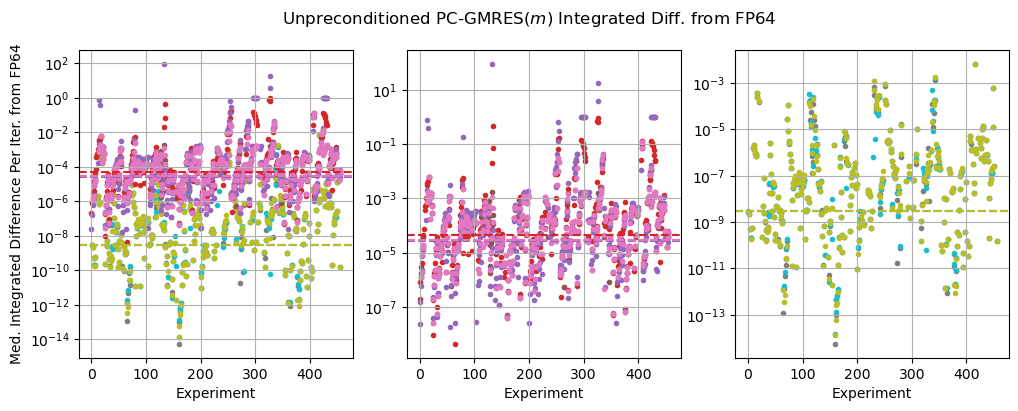

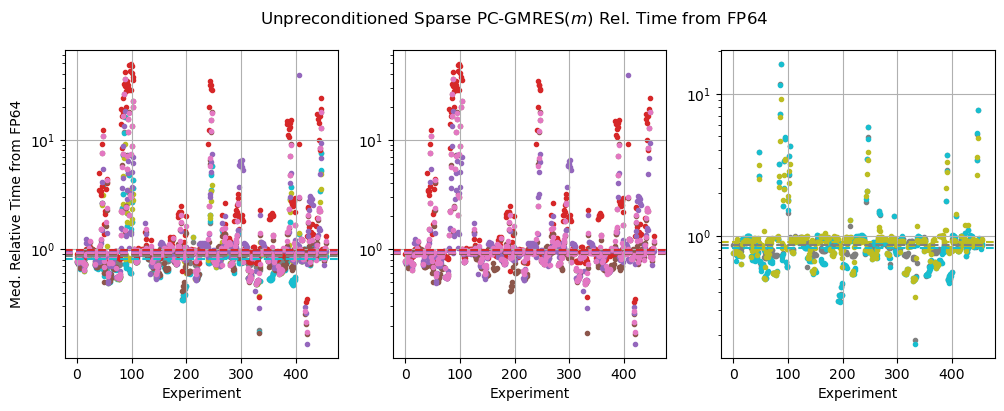

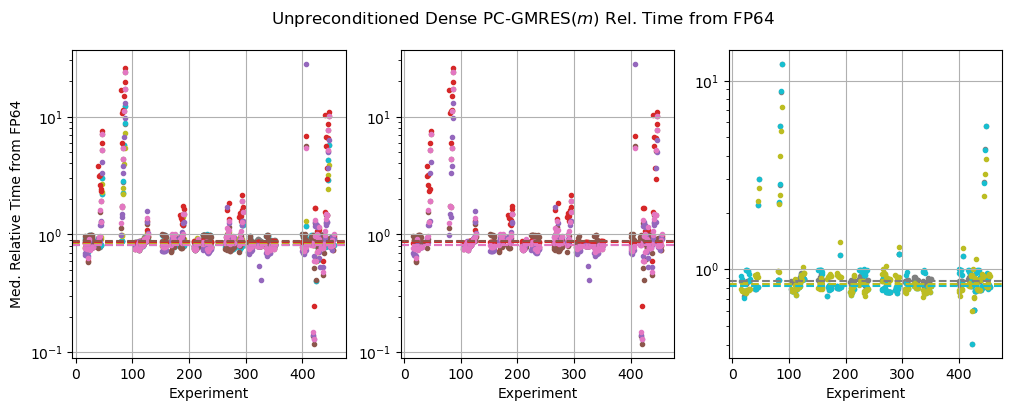

In [6]:
for setup, data_point, y_label, title, to_semilogy in [
    (
        "unprecond",
        "med_inner_integr_fp64_traj_diff_per_iter",
        "Med. Integrated Difference Per Iter. from FP64",
        "Unpreconditioned PC-GMRES($m$) Integrated Diff. from FP64",
        True
    ),
    (
        "unprecond",
        "med_rel_time",
        "Med. Relative Time from FP64",
        "Unpreconditioned Sparse PC-GMRES($m$) Rel. Time from FP64",
        True
    ),
    (
        "unpreconddense",
        "med_rel_time",
        "Med. Relative Time from FP64",
        "Unpreconditioned Dense PC-GMRES($m$) Rel. Time from FP64",
        True
    )
]:
    setup_data = median_data[median_data["setup" ] == setup]
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    ax1, ax2, ax3 = axs
    for solver in PC_SOLVERS:
        sub_data = setup_data[setup_data["solver"] == solver]
        sub_data = sub_data[
            ["setup", "matrix", "restart_param", data_point]
        ]
        plot_x = []
        plot_y = []
        for index, data in sub_data.iterrows():
            plot_x.append(
                UNIQUE_SETUP_ENUMERATION[
                    # (data["setup"],
                    ("unprecond", data["matrix"], data["restart_param"])
                ]
            )
            plot_y.append(data[data_point])
        if "HSD" in solver:
            scatter_axs = [ax1, ax2]
        else:
            scatter_axs = [ax1, ax3]
        for ax in scatter_axs:
            ax.scatter(
                plot_x,
                plot_y,
                color=SOLVER_CLR_DICT[solver],
                marker=".",
                label=solver
            )
            # ax.axhline(np.mean(plot_y), color=SOLVER_CLR_DICT[solver], linestyle=":")
            ax.axhline(np.median(plot_y), color=SOLVER_CLR_DICT[solver], linestyle="--")
    for ax in axs:
        if to_semilogy:
            ax.semilogy()
        ax.grid()
        ax.set_xlabel("Experiment")
    ax1.set_ylabel(y_label)

    fig.suptitle(title)

    plt.show()
        